In [1]:
import pydicom as dicom 
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import scipy.ndimage
from exercises_code import *
import glob


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
"""
Define Relevant Global Variables
"""
CT_PRE_LIVER_FILES = "HCC_005/01-23-1999-NA-ABDPELVIS-36548/2.000000-PRE LIVER-81126/*.dcm"
CT_RECON_LIVER_FILES = "HCC_005/01-23-1999-NA-ABDPELVIS-36548/4.000000-Recon 2 LIVER 3 PHASE AP-90548/*.dcm"
CT_PHASE_LIVER_FILES = "HCC_005/01-23-1999-NA-ABDPELVIS-36548/103.000000-LIVER 3 PHASE AP-85837/*.dcm"
SEGMENTATION_FILE = "HCC_005/01-23-1999-NA-ABDPELVIS-36548/300.000000-Segmentation-06660/1-1.dcm"


In [4]:
"""
Let's load up segmentation file since it seems easiest
"""
segmentation = dicom.dcmread(SEGMENTATION_FILE)
# flat data file does not have pixel spacing
seg_pixel = segmentation.pixel_array         # Get pixel array
print("Shape of the segmentation", seg_pixel.shape)


Shape of the segmentation (356, 512, 512)


# Understanding the segmentation header data 

So, this is a bit weird for me initially since I'm not sure how I'm going to put segmentation together with a bunch of dicom files but following the project hint to check the header. 
I followed and got the following header information:
1. Acquisition Number: The Acquisition Number is a DICOM attribute (tag) that identifies a specific acquisition set within a study. An acquisition is defined as a consecutive series of repetitive imaging instances sharing the same imaging parameters and conditions, typically used to distinguish different scans, sequences, or imaging techniques within the same study.
2. Slice Index: Not a standard DICOM tag but often refers to a user-defined or application-specific index to identify the position of a slice within a sequence of slices.
3. Per-frame Functional Groups Sequence: A sequence in DICOM that contains a collection of one or more items, where each item corresponds to a specific frame in a multi-frame image. Each item contains multiple functional group sequences that provide metadata applicable to that frame only.
4. Image Position Patient: A DICOM attribute within the Plane Position Sequence that describes the x, y, and z coordinates of the upper left hand corner of the image (first pixel transmitted) relative to a standard patient orientation.
5. Segment Identification Sequence: A sequence within DICOM that identifies the specific segment depicted in a frame. Each item in this sequence provides a link to the Segment Sequence, which describes the properties of the segment.
6. Referenced Segment Number: DICOM attribute within the Segment Identification Sequence indicates which segment from the Segment Sequence is visualized or analyzed in a given frame.


In [5]:
# pixel_array = actual data
seg_pix_arr = segmentation.pixel_array
# DICOM standard including detail information about each segment sequence
segs = segmentation.SegmentSequence
# SegmentNumber = uniquely identifies each segment within the segmentation
# SegmentLabel = which is a human-readable description or label of what each segment represents
seg_nums, seg_labels = (zip(*[(seg.SegmentNumber, seg.SegmentLabel) for seg in segs]))

In [6]:
"""
Per-Frame Functional Groups Sequence
a collection of data that describes attributes or parameters that vary from one frame to another within a multi-frame image. Each item in this sequence provides metadata specific to a single frame.

details the specific characteristics of each segment as it appears in individual frames

ImagePositionPatient = Extracts the exact position of the frame relative to the standard patient coordinate system

Dimension Index Values = indices used to reference the dimensional position of the frame within the entire image dataset

Referenced Segment Number = Indicates which specific segment (identified in another part of the DICOM file) is displayed in this frame.

Source Image Sequence = Provides a reference to the original Source Image from which this frame is derived, if applicable
"""

frames = segmentation.PerFrameFunctionalGroupsSequence
"""
Generally these plane position seq, frame conttent, etc only contain 1 in the sequence. 

DICOM standards often specify that certain information should only have a single value per frame in these sequences, particularly in segmentation and other specialized imaging modalities. Thus, developers and DICOM data handlers can rely on accessing the first item ([0]) knowing that it will contain the relevant data for the frame without ambiguity or variation.

Reasons: Efficiency, Simplicity
"""
patient_img_pos, dim_vals, ref_seg_nums, ref_sop_iuids = (
    zip(*[
        (f.PlanePositionSequence[0].ImagePositionPatient,
         f.FrameContentSequence[0].DimensionIndexValues,
         f.SegmentIdentificationSequence[0].ReferencedSegmentNumber,
         f.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID) for f in frames
    ])
)
segmentation_df = pd.DataFrame(data={
    "ImagePositionPatient": patient_img_pos,
    "DimensionIndexValues": dim_vals,
    "ReferencedSegmentNumber": ref_seg_nums,
    "ReferencedSOPInstanceUID": ref_sop_iuids
})

print("patient position:", patient_img_pos)
print("dimension index values:", dim_vals)
print("reference segment number:", ref_seg_nums)
print("reference SOP instance uid:", ref_sop_iuids)

patient position: ([-1.963000e+02, -2.100000e+02, -2.350000e+02], [-1.963000e+02, -2.100000e+02, -2.325000e+02], [-1.963000e+02, -2.100000e+02, -2.300000e+02], [-1.963000e+02, -2.100000e+02, -2.275000e+02], [-1.963000e+02, -2.100000e+02, -2.250000e+02], [-1.963000e+02, -2.100000e+02, -2.225000e+02], [-1.963000e+02, -2.100000e+02, -2.200000e+02], [-1.963000e+02, -2.100000e+02, -2.175000e+02], [-1.963000e+02, -2.100000e+02, -2.150000e+02], [-1.963000e+02, -2.100000e+02, -2.125000e+02], [-1.963000e+02, -2.100000e+02, -2.100000e+02], [-1.963000e+02, -2.100000e+02, -2.075000e+02], [-1.963000e+02, -2.100000e+02, -2.050000e+02], [-1.963000e+02, -2.100000e+02, -2.025000e+02], [-1.963000e+02, -2.100000e+02, -2.000000e+02], [-1.963000e+02, -2.100000e+02, -1.975000e+02], [-1.963000e+02, -2.100000e+02, -1.950000e+02], [-1.963000e+02, -2.100000e+02, -1.925000e+02], [-1.963000e+02, -2.100000e+02, -1.900000e+02], [-1.963000e+02, -2.100000e+02, -1.875000e+02], [-1.963000e+02, -2.100000e+02, -1.850000e

# Loading related CT files
With all the relevant information retrieved from Segmentation file, we shall now retrieve data data from DICOM Liver. 

In [7]:
# loading all dicom files
ct_dicom_files = glob.glob(CT_PHASE_LIVER_FILES)
loaded_ct_files = [dicom.dcmread(f) for f in ct_dicom_files]
ct_images = {f.SOPInstanceUID: f for f in loaded_ct_files}
print('Number of Phase Liver CT:', len(ct_images))
print(ct_images.keys())

Number of Phase Liver CT: 89
dict_keys(['1.3.6.1.4.1.14519.5.2.1.1706.8374.256856271982949194978880859241', '1.3.6.1.4.1.14519.5.2.1.1706.8374.326908718665071230950475019945', '1.3.6.1.4.1.14519.5.2.1.1706.8374.139080550644953533631381096834', '1.3.6.1.4.1.14519.5.2.1.1706.8374.546102526901955939750378151852', '1.3.6.1.4.1.14519.5.2.1.1706.8374.103896201960946229834447481410', '1.3.6.1.4.1.14519.5.2.1.1706.8374.746876633457660546228664476474', '1.3.6.1.4.1.14519.5.2.1.1706.8374.290102744870829052615109114308', '1.3.6.1.4.1.14519.5.2.1.1706.8374.159990375599301808138499397076', '1.3.6.1.4.1.14519.5.2.1.1706.8374.808448432209244110755132928077', '1.3.6.1.4.1.14519.5.2.1.1706.8374.112947859402884630337515212592', '1.3.6.1.4.1.14519.5.2.1.1706.8374.216429978104569985410711101807', '1.3.6.1.4.1.14519.5.2.1.1706.8374.259531401290950910527058518590', '1.3.6.1.4.1.14519.5.2.1.1706.8374.204486663146879804135135027290', '1.3.6.1.4.1.14519.5.2.1.1706.8374.806007742727212060624312311220', '1.3.6.1

In [8]:
# all SOP Instance UID found
matched_ct_images = []
for sop_uid in segmentation_df['ReferencedSOPInstanceUID'].unique():
    if sop_uid in ct_images:
        matched_ct_images.append(ct_images[sop_uid])
    else:
        print(f"Warning: No CT image found for SOP Instance UID {sop_uid}")
print('matched ct',len(matched_ct_images))


matched ct 89


In [9]:
# get all meta data of the images
meta_of_images = []
attributes_to_collect = ['SliceLocation', 'AcquisitionNumber', 'SeriesNumber',
                         'ImagePositionPatient', 'ImageType', 'InstanceNumber',
                         'SOPInstanceUID']
for ct_image in matched_ct_images:
    # Dictionary to store the extracted metadata
    extracted_metadata = {}
    # Extract metadata
    for attr in attributes_to_collect:
        # Safely get the attribute value to avoid errors if the attribute does not exist
        extracted_metadata[attr] = getattr(ct_image, attr, None)
    meta_of_images.append(extracted_metadata)
print(len(meta_of_images))

89


In [10]:
# Comparing Headers of Segmentation and Metadata of loaded CT images
meta_data_df = pd.DataFrame(
    data=meta_of_images
)
print("shape of segmentation: ", segmentation_df.shape)
print("shape of ct images: ", meta_data_df.shape)
display(segmentation_df.head())
display(meta_data_df[attributes_to_collect[:-1]].head())

shape of segmentation:  (356, 4)
shape of ct images:  (89, 7)


,ImagePositionPatient,DimensionIndexValues,ReferencedSegmentNumber,ReferencedSOPInstanceUID
0,"[-1.963000e+02, -2.100000e+02, -2.350000e+02]","[1, 1]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.125961789216...
1,"[-1.963000e+02, -2.100000e+02, -2.325000e+02]","[1, 2]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.157561489969...
2,"[-1.963000e+02, -2.100000e+02, -2.300000e+02]","[1, 3]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.142109327395...
3,"[-1.963000e+02, -2.100000e+02, -2.275000e+02]","[1, 4]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.339980100246...
4,"[-1.963000e+02, -2.100000e+02, -2.250000e+02]","[1, 5]",1,1.3.6.1.4.1.14519.5.2.1.1706.8374.326134769461...


,SliceLocation,AcquisitionNumber,SeriesNumber,ImagePositionPatient,ImageType,InstanceNumber
0,-235.0,3,103,"[-196.300003, -210.000000, -235.000000]","[ORIGINAL, SECONDARY, AXIAL]",89
1,-232.5,3,103,"[-196.300003, -210.000000, -232.500000]","[ORIGINAL, SECONDARY, AXIAL]",88
2,-230.0,3,103,"[-196.300003, -210.000000, -230.000000]","[ORIGINAL, SECONDARY, AXIAL]",87
3,-227.5,3,103,"[-196.300003, -210.000000, -227.500000]","[ORIGINAL, SECONDARY, AXIAL]",86
4,-225.0,3,103,"[-196.300003, -210.000000, -225.000000]","[ORIGINAL, SECONDARY, AXIAL]",85


In [11]:
# Referenced SOPInstanceUID and Referenced SOPInstanceUID 
# are the same so we can merge here 
# with shape of (356,4) and (89,8)
merged_df = pd.merge(segmentation_df, meta_data_df, left_on='ReferencedSOPInstanceUID', right_on='SOPInstanceUID', how='inner' )
print("new merged df shape:",merged_df.shape)
print("shape of segmentation pixel array", segmentation.pixel_array.shape)
print("why 4 duplicate? because the number of labels is:", len(seg_labels))
# However, the shape becomes 1424, this means that each SOPInstanceUID corresponds to 4 ReferencedSOPInstanceUID? Hence, the 4 times more. 
# Here upon further inspection
# there are 89 unique ReferencedSOPInstanceUID and SOPInstanceUID.
# meaning each ReferencedSOPInstanceUID is 
# meaning that 4 segments belongs to each dicom.
print(segmentation_df['ReferencedSOPInstanceUID'].unique().shape)
print(meta_data_df['SOPInstanceUID'].unique().shape)
print("To make sure that our idea of all 4 segment per segment initially is correct")
print(all(4 == segmentation_df['ReferencedSOPInstanceUID'].value_counts().to_numpy()))

new merged df shape: (356, 11)
shape of segmentation pixel array (356, 512, 512)
why 4 duplicate? because the number of labels is: 4
(89,)
(89,)
To make sure that our idea of all 4 segment per segment initially is correct
True


Here we check if the merged data frame has matched image position. The answer is yes if we have tolerence for floating point error.

In [12]:
# let us check if patient position are the same once merged
def apply_is_image_position_same(row):
    # Here we check if 2 list of image position is the same or not
    # we assume they should be the same and that there should be some floating point error
    x = row['ImagePositionPatient_x']
    y = row['ImagePositionPatient_y']
    return all(np.isclose(x, y, atol=1e-7, rtol=1e-5))
is_all_image_position_matched = all(merged_df.apply(apply_is_image_position_same, axis=1).to_numpy())
print("This cell check if the merged patient position matched: ", is_all_image_position_matched)

This cell check if the merged patient position matched:  True


Therefore, the only variable that is constantly changing is SliceLocation. 

We expect that each UID will have 4 different segments. We have to fuse the original data and different segments together. So we first get an easy way to access pixel data of CT images. 

In [13]:
print("Is all Acquisition Number is the same:", all(merged_df['AcquisitionNumber'].to_numpy()))
"""
since segmentation array shape and merged df matched
we can safely load up image pixel data accordingly 
"""
# we want an easy way to refer to data slice 
slice_loc_to_pixel = {}
for image in matched_ct_images:
    # originally dicom DS float so need to convert to float
    slice_loc_to_pixel[float(image.SliceLocation)] = image.pixel_array
sorted_keys = sorted(slice_loc_to_pixel.keys())

Is all Acquisition Number is the same: True


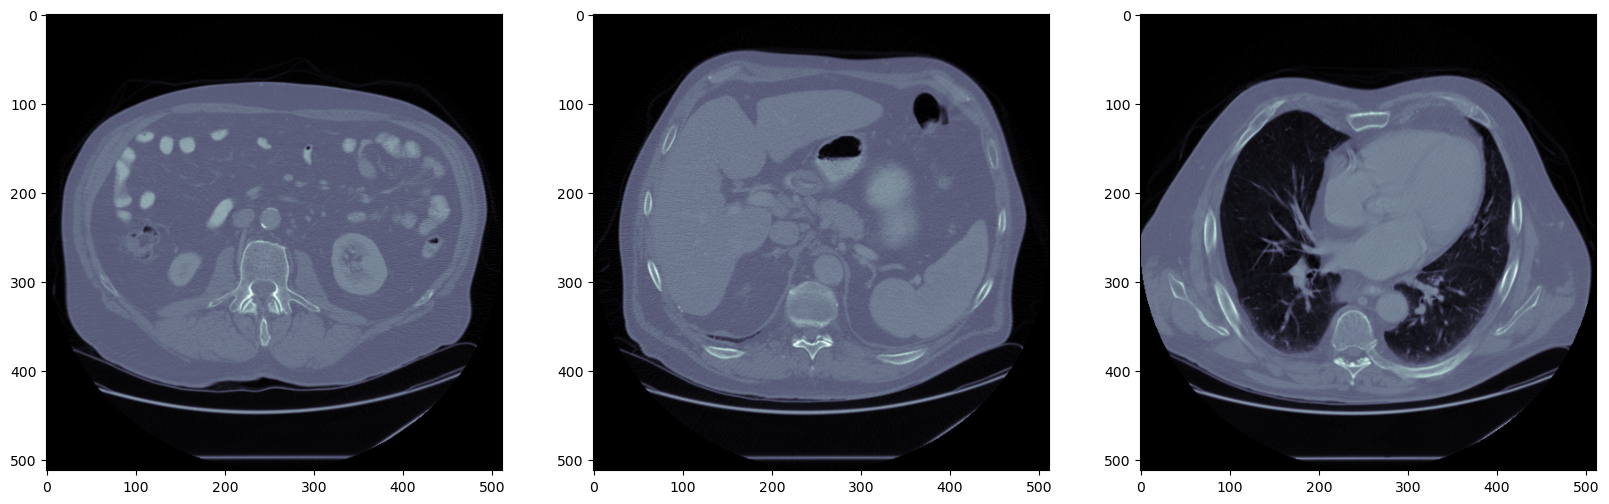

In [14]:
# Let's show some slices from lowest SliceLocation to Median to Highest 
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axes[0].imshow(slice_loc_to_pixel[sorted_keys[0]], cmap='bone')
axes[1].imshow(slice_loc_to_pixel[sorted_keys[88//2]], cmap='bone')
axes[2].imshow(slice_loc_to_pixel[sorted_keys[88]], cmap='bone')
plt.show()

# Fusing CT images and Segmentations
Remember previously that we have 4 labels.

These labels correspond to the 89*4 size of segmentation 

From further exploration, it seems that ReferencedSegmentNumber refers to the label directly so:
1. Liver (1)
2. Mass (2)
3. Portal (3)
4. Abdominal Aorta (4)

Furthermore, the segmentation_df seems to be arranged in such a way that all of a referenced segment are put together from lowest SliceLocation to highest slice location.



array([[[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        ...,
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        ...,
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        ...,
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75]],

       ...,

       [[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        ...,
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        .

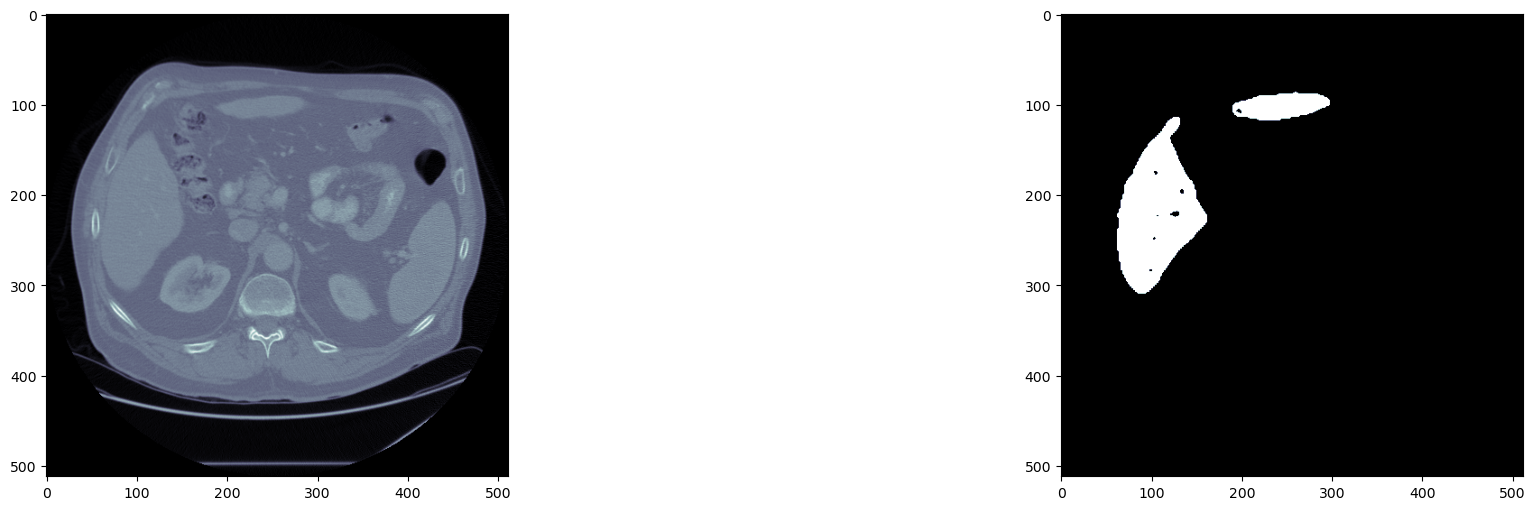

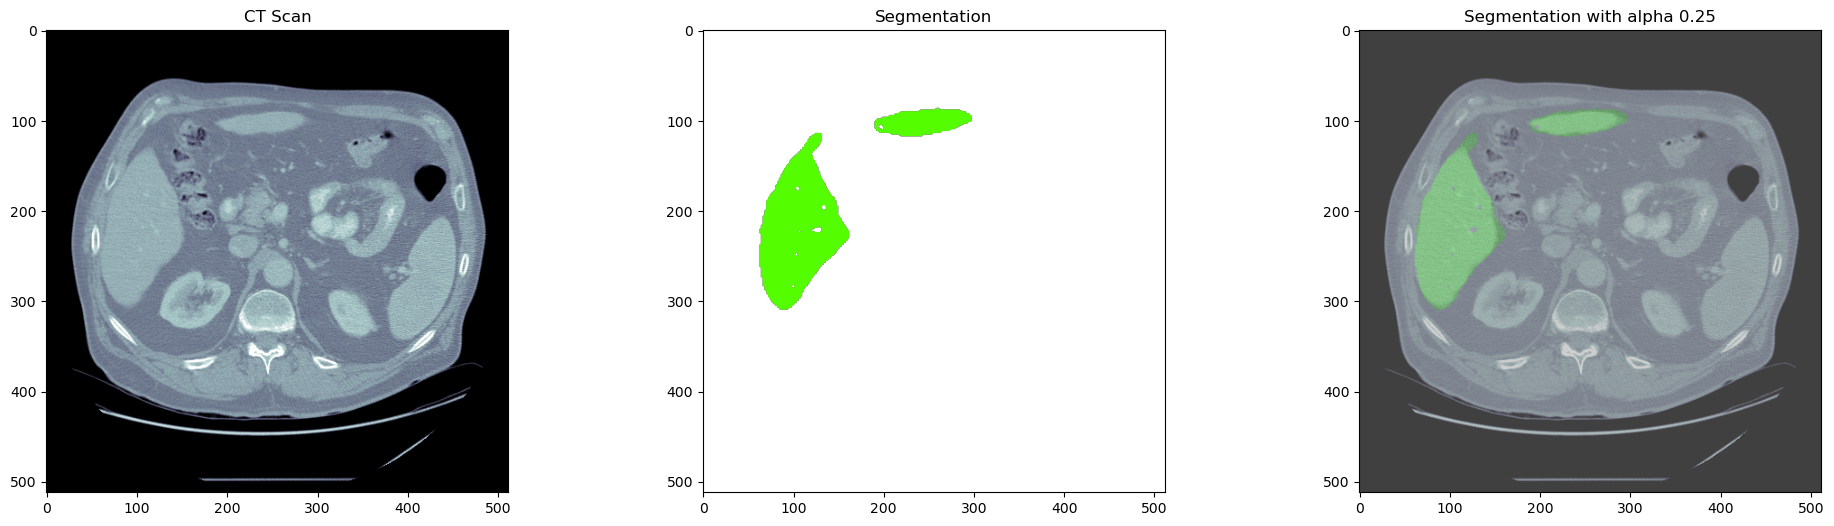

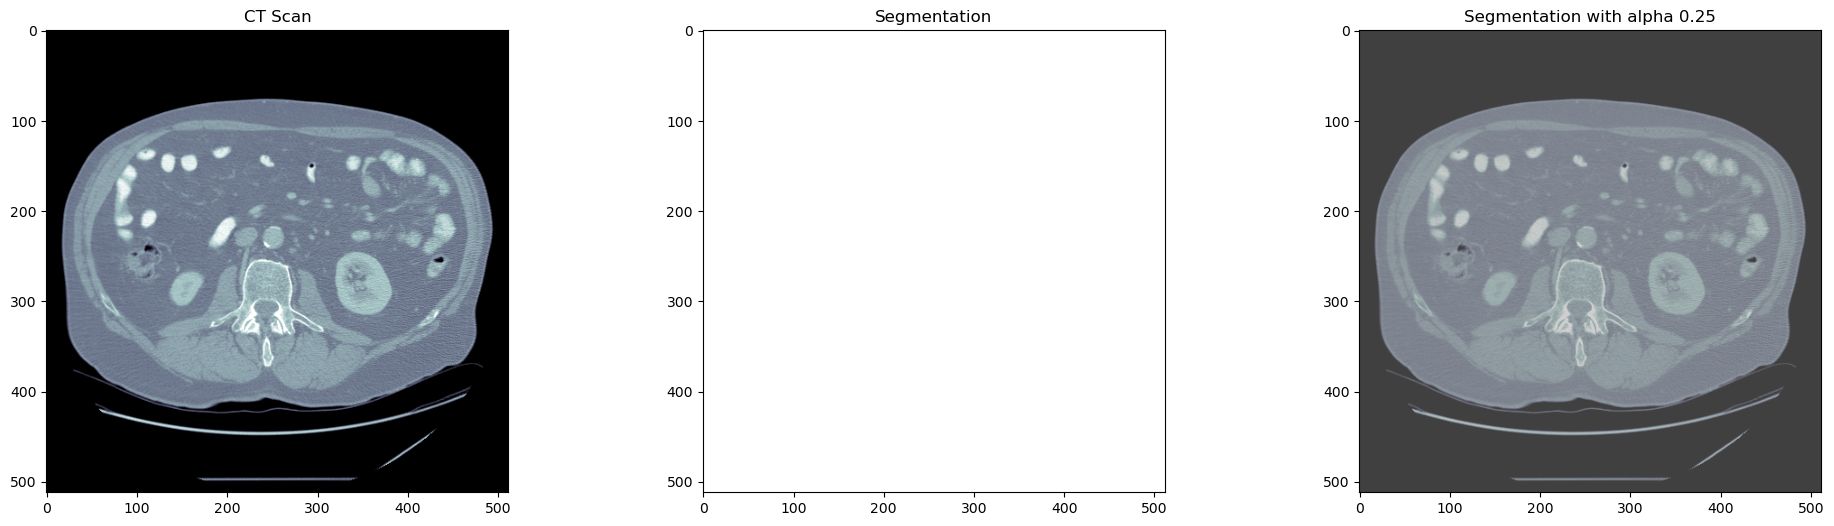

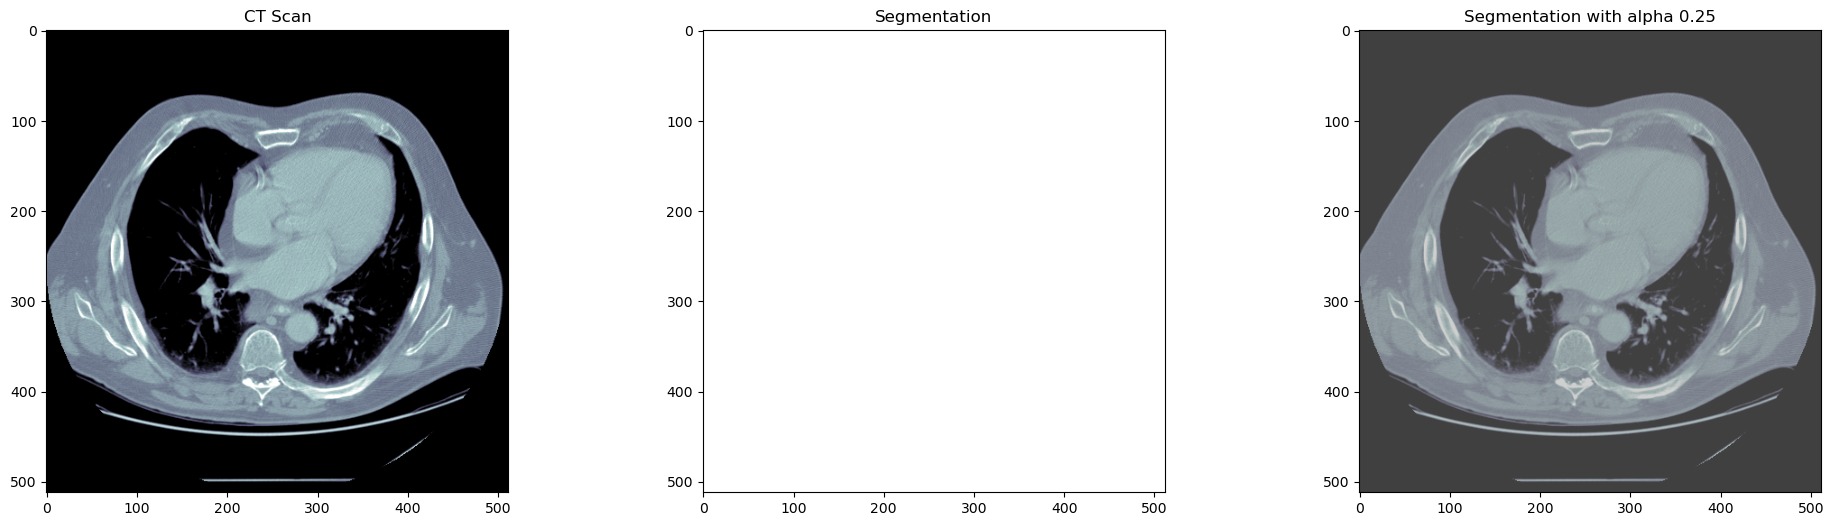

In [15]:
def get_relevant_data(idx, seg_ref_num, slice_dict, segmentation_dcm):
    """
    Get relevant slice of CT Image and segmentation given index and segment reference number
    Assumption: segmentation dcm arrange each group of slice sequentially and that the items in each group is sorted from lowest Slice Number to highest Slice Number
    :param idx: 
    :param seg_ref_num: 
    :param segmentation_dcm: 
    :param slice_dict: 
    :return: 
    """ 
    slice_sorted_keys = list(sorted(slice_dict.keys()) )
    seg_ref_mult = seg_ref_num-1
    assert 0 <= idx <= len(sorted_keys) - 1, "Index out of bound!"
    return (slice_dict[slice_sorted_keys[idx]],
            segmentation_dcm.pixel_array[idx + seg_ref_mult*len(sorted_keys), : , :]) 


def plot_side_by_side(all_images):
    # Let's show some slices from lowest SliceLocation to Median to Highest 
    _, axes = plt.subplots(nrows=1, ncols=len(all_images), figsize=(24, 6))
    for i, ax in enumerate(axes):
        ax.imshow(all_images[i], cmap='bone')

# Let's show some liver
slice, seg = get_relevant_data(30, 1, slice_loc_to_pixel, segmentation)
# example of original image
plot_side_by_side([slice, seg])
# side by side comparison
slice, seg = get_relevant_data(30, 1, slice_loc_to_pixel, segmentation)
visualize_alpha_fusion(slice, seg)
# Lowest - notice that for liver, slice 0 does not have it 
slice, seg = get_relevant_data(0, 1, slice_loc_to_pixel, segmentation)
visualize_alpha_fusion(slice, seg)
# Highest - notice that for liver, slice 88 does not have it
slice, seg = get_relevant_data(88, 1, slice_loc_to_pixel, segmentation)
visualize_alpha_fusion(slice, seg)

(array([[487.,   2.,   1., ...,   0.,   0.,   0.],
        [473.,   1.,   1., ...,   0.,   0.,   0.],
        [462.,   2.,   1., ...,   0.,   0.,   0.],
        ...,
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-1024. ,  -801.7,  -579.4,  -357.1,  -134.8,    87.5,   309.8,
          532.1,   754.4,   976.7,  1199. ]),
 <a list of 512 BarContainer objects>)

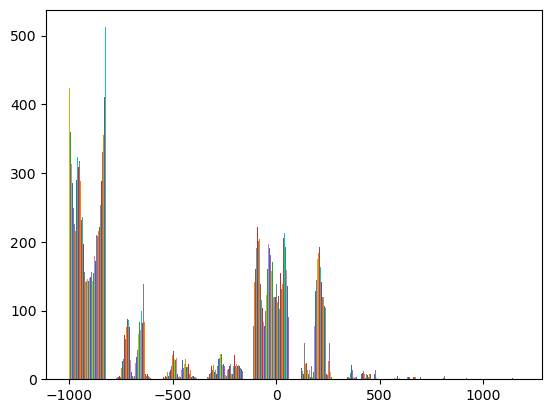

In [16]:
"""
Here we plot histogram of pixels in slice in order to determine lower and upper filter

In this case we can see that there are cluster on negative values, we would like to remove this to have less noise.

Furthermore, we also want to filter things more than 500.

We set these values to same negative values as cutoff points so that it's easier to see
"""
plt.hist(slice)

array([[[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        ...,
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        ...,
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        ...,
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75]],

       ...,

       [[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        ...,
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        [0.  , 0.  , 0.  , 0.75],
        .

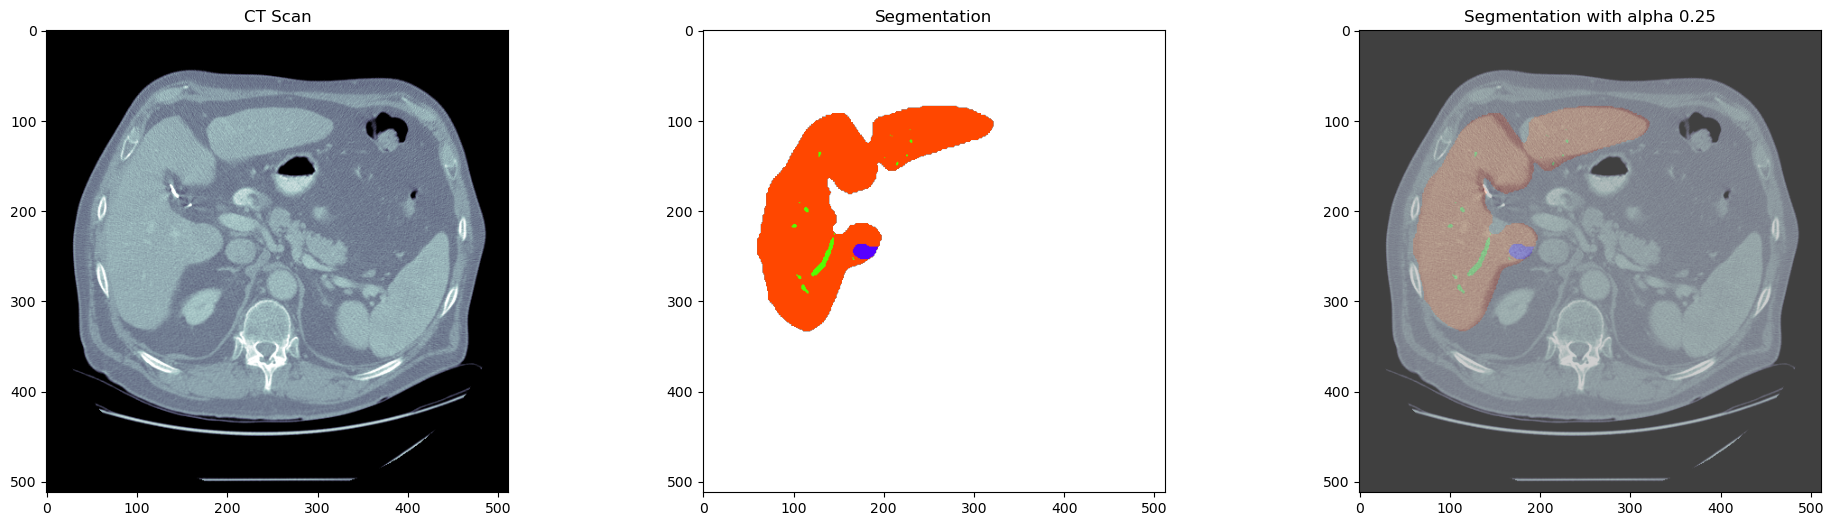

In [17]:
# Let's plot all the segments together
def get_slice_with_all_segments(idx, total_no_seg, slice_dict, segmentation_dcm):
    # A more complex images version of above function by fusing all segmnets together
    assert 0 <= idx <= len(sorted_keys) - 1, "Index out of bound!"
    slice_sorted_keys = list(sorted(slice_dict.keys()) )
    weights = np.ones(total_no_seg) * np.linspace(0.2, 0.9, total_no_seg)
    slice = slice_dict[slice_sorted_keys[idx]]
    all_segment_mask = np.zeros(slice.shape)
    for s in range(total_no_seg):
        # s = 0, 1, 2, 3 -> should be consistent here 
        mask = segmentation_dcm.pixel_array[idx + s*len(sorted_keys), : , :]
        all_segment_mask += (mask * weights[s])
    return (slice,
            all_segment_mask)
slice, fused_seg = get_slice_with_all_segments(40, len(seg_labels), slice_loc_to_pixel, segmentation)
visualize_alpha_fusion(slice, fused_seg)

In [18]:
# Finally
# Furthermore, let's put the pixel data together 
# Let's combine 4 set of segmentation into 1 fused segmentation 
total_images = len(slice_loc_to_pixel)
single_image_dcm = []
single_segmentation = np.zeros((total_images, slice.shape[0], slice.shape[1]))
for i in range(len(slice_loc_to_pixel)):
    slice, fused_seg = get_slice_with_all_segments(i, len(seg_labels), slice_loc_to_pixel, segmentation)
    single_segmentation[i, :, :] = fused_seg
    single_image_dcm.append(slice)
single_image_dcm = np.array(single_image_dcm)
print(single_segmentation.shape)
print(single_image_dcm.shape)

unique_vals, counts = np.unique(single_segmentation, return_counts=True)
# + 1 cus 0 
assert len(unique_vals) == len(seg_labels)+1, "unique counts are not equal to number of segmentation regions"

(89, 512, 512)
(89, 512, 512)


# Making the Animation

When performing reconstruction, we need to get the actual pixel spacing and slice thickness in order to make sure that the aspect showing the item is correct. 

MIP_sagittal_plane is done in class

rotate_on_axial_plane is also done in class

So what we shall do is to fix  show sagittal plane in MIP and rotate on axial plane.

This require angle. We first define the number of frames we want our gif to be and calculate the angle, this is so that we can rotate full 360 degree for the duration of the gif. 

steps:
1. Rotate both ct scan and segment
2. Alpha fuse both ct scan and segment
3. Then make animation.

In [19]:
# define all required data 
print('Slice Thickness', matched_ct_images[0].SliceThickness)
print('Pixel Spacing', matched_ct_images[0].PixelSpacing)
pixel_len_mm = [float(matched_ct_images[0].SliceThickness), 
                matched_ct_images[0].PixelSpacing[0],
                matched_ct_images[0].PixelSpacing[1]]
aspect_ratio = pixel_len_mm[0] / pixel_len_mm[1]
cm = matplotlib.colormaps.get_cmap('bone')
no_imgs_in_gif = 40 
# we do this so that we don't have 360 rotation since it's the same as 0 
# it would look really weird if there's both 0 and 360 
angles = np.linspace(0, 360*(no_imgs_in_gif-1)/no_imgs_in_gif, num=no_imgs_in_gif)
print("set number of images in gif", no_imgs_in_gif, )
print("angles to rotate", angles)

Slice Thickness 2.500000
Pixel Spacing [0.820312, 0.820312]
set number of images in gif 40
angles to rotate [  0.   9.  18.  27.  36.  45.  54.  63.  72.  81.  90.  99. 108. 117.
 126. 135. 144. 153. 162. 171. 180. 189. 198. 207. 216. 225. 234. 243.
 252. 261. 270. 279. 288. 297. 306. 315. 324. 333. 342. 351.]


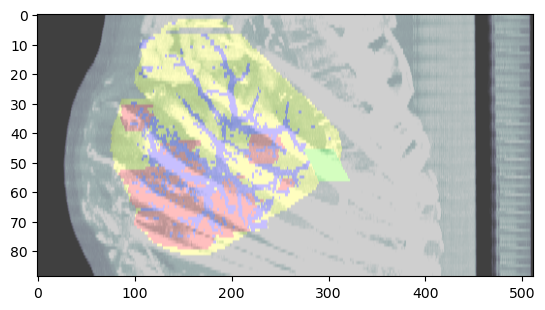

In [20]:
def axial_rotate_and_mip_projection(img, angle):
    return MIP_sagittal_plane(rotate_on_axial_plane(img, angle))
    
# get all rotation and fused img to display for animation 
fused_images_for_animation = []
for idx, angle in enumerate(angles):
    sagittal_seg = axial_rotate_and_mip_projection(single_segmentation, angle)
    sagittal_ct = axial_rotate_and_mip_projection(single_image_dcm, angle)
    fused_img = visualize_alpha_fusion(sagittal_ct, sagittal_seg, visualize=False)
    fused_images_for_animation.append(fused_img)

fig, ax = plt.subplots()
animation_data = [
    [
        plt.imshow(img, 
                   animated=True, 
                   vmin=np.amin(single_segmentation),
                   vmax=np.amax(single_segmentation),
                   cmap=cm, aspect=aspect_ratio)
    ]
    for img in fused_images_for_animation
]
all_seg_rot_gif = animation.ArtistAnimation(fig, animation_data, interval=120, blit=True)
all_seg_rot_gif.save('./all_segments.gif')  